In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv
/kaggle/input/rsna-breast-cancer-detection/train.csv
/kaggle/input/rsna-breast-cancer-detection/test.csv
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/937109986.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/34700621.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/10706/1167990339.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1291014447.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/831671840.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1481837831.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/21867/851000290.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1724313070.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1816992952.dcm
/kaggle/input/rsna-breast-cancer-detection/train_images/34867/1416

⭐️⭐️RSNA Screening Mammograpy Breast Cancer Detection⭐️⭐️
Steps:
1. Import Necessary Library
2. Load and analysis the data
3. Preprocessing
4. KFOLD
5. Build the Model
6. Predict Output
7. Generate Submission file

# importing Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import missingno as msno
import plotly.graph_objs as go
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
#Preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
#Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [3]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
sample = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')
train_image_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
test_image_path = '/kaggle/input/rsna-breast-cancer-detection/test_images'

In [4]:
print(f'Train_Shape: {train.shape},Test_Shape: {test.shape},Sample_Shape: {sample.shape}')
display(train.sample(2))
display(test.sample(2))
display(sample.sample(2))

Train_Shape: (54706, 14),Test_Shape: (4, 9),Sample_Shape: (2, 2)


site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
55           1       10102  1304802631          L   CC  40.0       0       0   
18195        2       29222   457117110          L  MLO  54.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  
55            0     NaN        0       B          49                    False  
18195         0     NaN        0     NaN          21                    False

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
2        2       10008    68070693          R  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   

  prediction_id  
2       10008_R  
1       10008_L

prediction_id    cancer
1       10008_R  0.021168
0       10008_L  0.021168

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

# Data Description

* [train/test]_images/[patient_id]/[image_id].dcm The mammograms, in dicom format. You can expect roughly 8,000 patients in the hidden test set. There are usually but not always 4 images per patient. Note that many of the images use the jpeg 2000 format which may you may need special libraries to load.

* sample_submission.csv A valid sample submission. Only the first few rows are available for download.
* [train/test].csv Metadata for each patient and image. Only the first few rows of the test set are available for download.

* site_id - ID code for the source hospital.
* patient_id - ID code for the patient.
* image_id - ID code for the image.
* laterality - Whether the image is of the left or right breast.
* view - The orientation of the image. The default for a screening exam is to capture two views per breast.
* age - The patient's age in years.
* implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
* density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult.
* machine_id - An ID code for the imaging device.
* cancer - The target value. Only provided for train.
* biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
* invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
* BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
* prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
* difficult_negative_case - True if the case was unusually difficult. Only provided for train.

# Target variable

<AxesSubplot:xlabel='cancer', ylabel='count'>

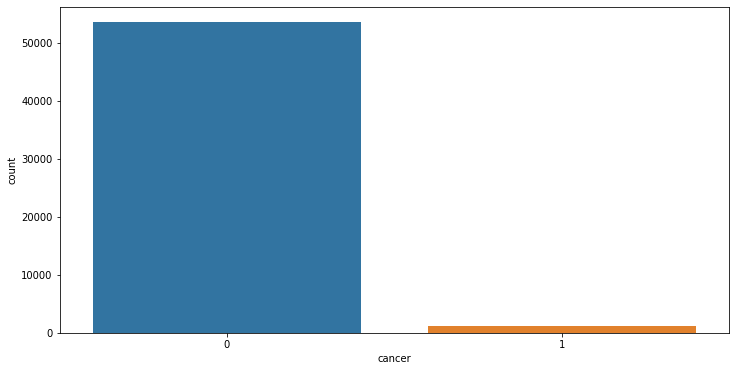

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x=train.cancer)

In [7]:
print(train.cancer.value_counts(ascending=False))
print(1158/(53548+1158)*100)

0    53548
1     1158
Name: cancer, dtype: int64
2.11676964135561


Cancer positive 2.1% only..Imabalanced dataset

1 is cancer prone and 0 is negative

In [8]:
train.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

In [9]:
train.describe()

site_id    patient_id      image_id           age        cancer  \
count  54706.000000  54706.000000  5.470600e+04  54669.000000  54706.000000   
mean       1.460407  32698.865262  1.079386e+09     58.543928      0.021168   
std        0.498434  18893.861534  6.183269e+08     10.050884      0.143944   
min        1.000000      5.000000  6.849100e+04     26.000000      0.000000   
25%        1.000000  16481.000000  5.458153e+08     51.000000      0.000000   
50%        1.000000  32432.000000  1.082689e+09     59.000000      0.000000   
75%        2.000000  48999.000000  1.613228e+09     66.000000      0.000000   
max        2.000000  65534.000000  2.147472e+09     89.000000      1.000000   

             biopsy      invasive        BIRADS       implant    machine_id  
count  54706.000000  54706.000000  26286.000000  54706.000000  54706.000000  
mean       0.054272      0.014953      0.772350      0.026999     54.618378  
std        0.226556      0.121365      0.590062      0.162081     44.784800  
min        0.000000      0.000000      0.000000      0.000000     21.000000  
25%        0.000000      0.000000      0.000000      0.000000     29.000000  
50%        0.000000      0.000000      1.000000      0.000000     49.000000  
75%        0.000000      0.000000      1.000000      0.000000     49.000000  
max        1.000000      1.000000      2.000000      1.000000    216.000000

Age ranges from 26 to 89 with a mean of 58years

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

>  Birads and density columns are having null values

<AxesSubplot:>

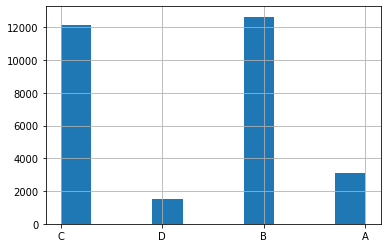

In [11]:
train['density'].hist()

density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult.

Here we are observing Least for D density!!Good but let's see other columns as well

<AxesSubplot:xlabel='age', ylabel='Density'>

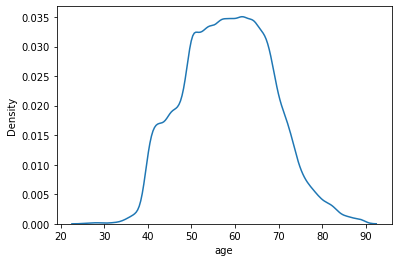

In [12]:
sns.kdeplot(x=train['age'])

<AxesSubplot:>

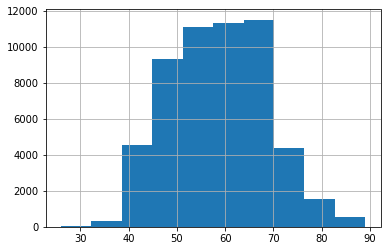

In [13]:
train['age'].hist()

In [14]:
train.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

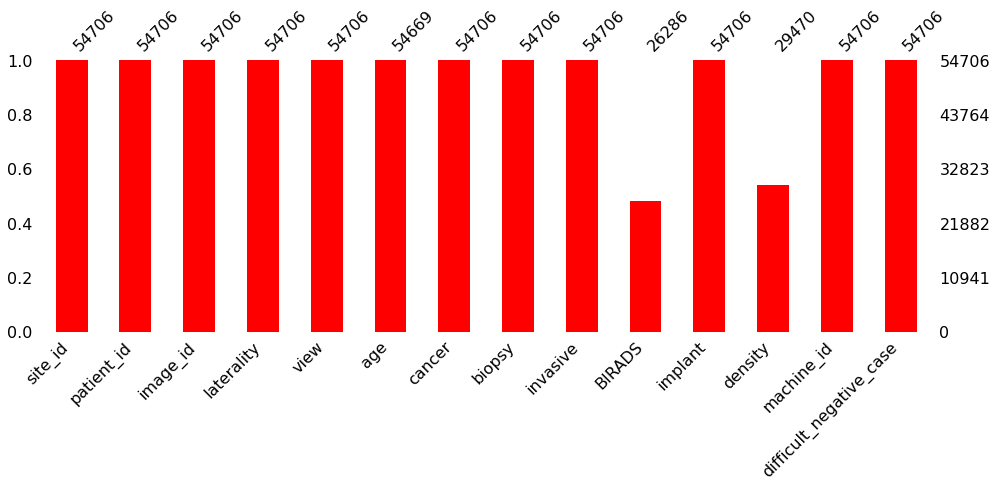

In [15]:
msno.bar(train,figsize=(16,5),color='red')
plt.show()

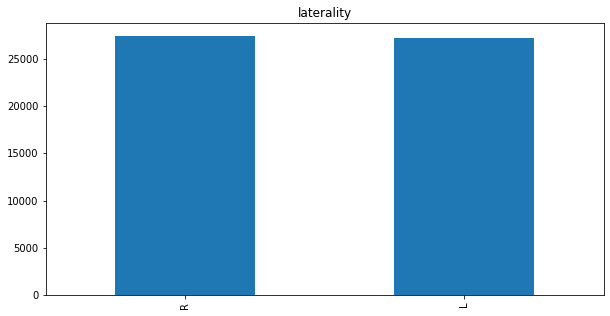

In [16]:
train['laterality'].value_counts().plot(kind='bar',figsize = (10, 5))
plt.title('laterality')
plt.show()

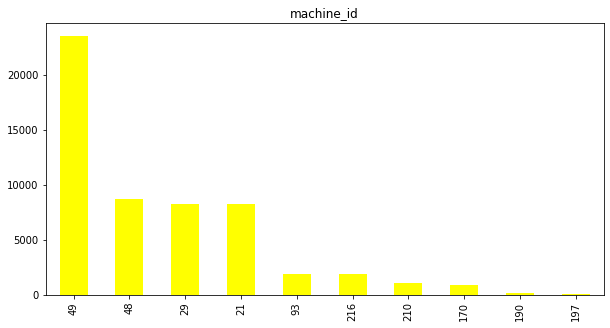

In [17]:
train['machine_id'].value_counts().plot(kind='bar',figsize = (10, 5),color="yellow")
plt.title('machine_id')
plt.show()

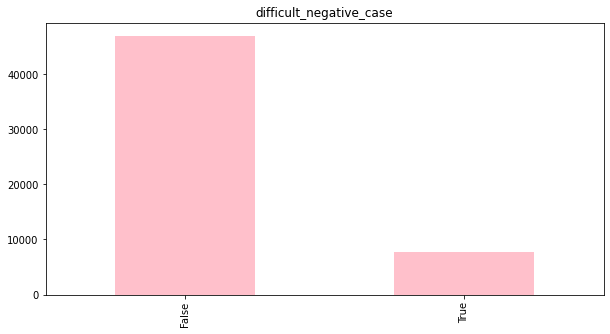

In [18]:
train['difficult_negative_case'].value_counts().plot(kind='bar',figsize = (10, 5),color="pink")
plt.title('difficult_negative_case')
plt.show()

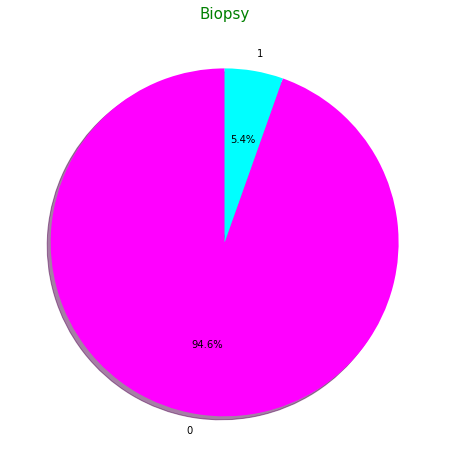

In [19]:
labels = train["biopsy"].value_counts().index
sizes = train["biopsy"].value_counts()
colors = ['magenta','cyan',"orange","yellow"]
plt.figure(figsize = (8,8))
plt.pie(sizes, labels=labels, rotatelabels=False, autopct='%1.1f%%',colors=colors,shadow=True, startangle=90)
plt.title('Biopsy',color = 'green',fontsize = 15)
plt.show()

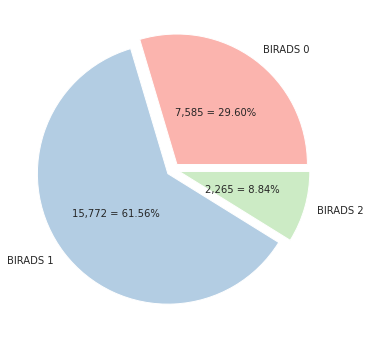

In [20]:
plt.subplots(figsize=(6, 6))
sns.set_style('darkgrid')
sns.set_palette('Pastel1')

data = [
    train[(train["cancer"] == 0) & (train["BIRADS"] == 0.0)]["image_id"].count(),
    train[(train["cancer"] == 0) & (train["BIRADS"] == 1.0)]["image_id"].count(),
    train[(train["cancer"] == 0) & (train["BIRADS"] == 2.0)]["image_id"].count(),
]
counts = pd.DataFrame()
_ = plt.pie(
    data, labels=["BIRADS 0", "BIRADS 1", "BIRADS 2"],
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
    explode=[0.05] * 3, 
    pctdistance=0.5, 
    colors=sns.color_palette("Pastel1")[0:3],
)

# There are 7 main BI-RADS scores, or categories:
* 0 - Need additional imaging evaluation
* 1 - Negative
* 2 - Benign
* 3 - Probably Benign
* 4 - Suspicious
* 5 - Highly Suggestive of Malignancy
* 6 - Known Biopsy-Proven Malignancy¶
* Screening mammograms can only be assigned a BI-RADS score of 0, 1, or 2. This is why the dataset only contains 3 of the BI-RADS categories

<AxesSubplot:>

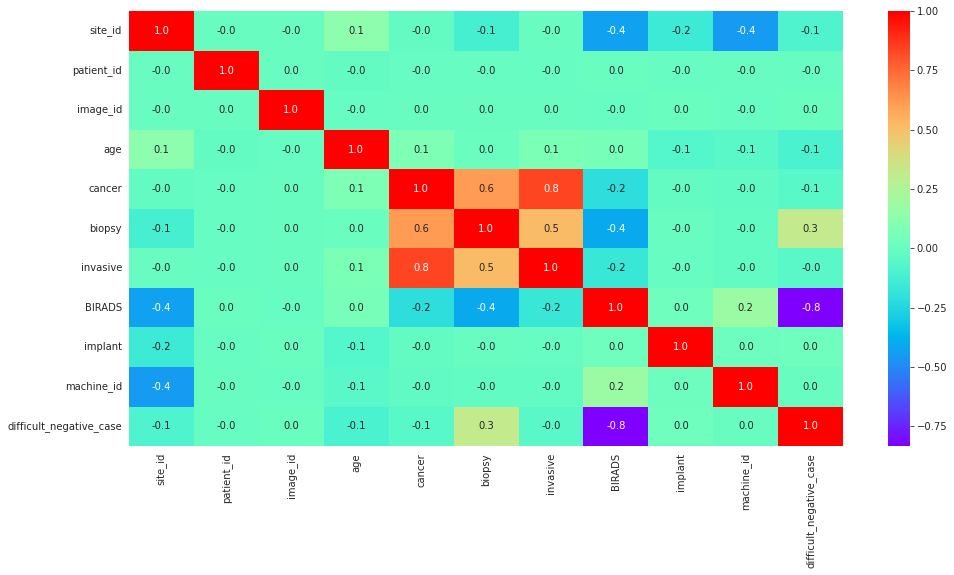

In [21]:
plt.figure(figsize=(16,8))
sns.heatmap(train.corr(),annot=True,cmap='rainbow',fmt='.1f')

## Invasive, Biopsy are correlated with cancer in a positive manner where as BIRADS,difficult_nagative_case in oppiste manner

### In this data set, the number of people for whom biopsy is requested with the suspicion of cancer is in the minority.

* 🔵 In BIRADS 1-2, we see that the possibility of cancer is almost nonexistent.
* 🔵 We see that the risk of cancer increases in the age range of 50-70 years.
* 🔵 We see that this data set mostly consists of BI RADS-1.
* 🔵 Since the density b and c are too much in the dataset, the cancer rate seems higher, but it may not be right to say this because the dataset contains NaN values ​​too much.
* 🔵 A patient under 30 years of age who underwent biopsy is not possible for this data set.


# K fold

In [22]:
#add extra one columns
train['kfold']=-1
#Distributing the data 5 shares
kfold = model_selection.KFold(n_splits=5, shuffle= True, random_state = 12)
for fold, (train_indicies, valid_indicies) in enumerate(kfold.split(X=train)):
    #print(fold,train_indicies,valid_indicies)
    train.loc[valid_indicies,'kfold'] = fold    
print(train.kfold.value_counts()) #total data 300000 = kfold split :5 * 60000
#output of train folds data
train.to_csv("trainfold_5.csv",index=False)

0    10942
4    10941
2    10941
3    10941
1    10941
Name: kfold, dtype: int64


# Preprocessing - Categorical to Numerical data

In [23]:
##Converting all categorical data to numerical
train['view'] =train['view'].astype('category').cat.codes
train['density'] =train['density'].astype('category').cat.codes
train['laterality'] =train['laterality'].astype('category').cat.codes
train['difficult_negative_case'] =train['difficult_negative_case'].astype('category').cat.codes


test['prediction_id'] =test['prediction_id'].astype('category').cat.codes
test['view'] =test['view'].astype('category').cat.codes
test['laterality'] = test['laterality'].astype('category').cat.codes

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  int8   
 4   view                     54706 non-null  int8   
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  54706 non-null  int8   
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  int8   
 14  kfold                 

# KNN imputer

 let us say we have variables related to the density of cars on road and levels of pollutants in the air and there are few observations that are missing for the level of pollutants, imputing the level of pollutants by mean/median level of pollutants may not necessarily be an appropriate strategy.

In such scenarios, algorithms like k-Nearest Neighbors (kNN) can help to impute the values of missing data. Sociologists and community researchers suggest that human beings live in a community because neighbors generate a feeling of security and safety, attachment to community, and relationships that bring out a community identity through participation in various activities.

In [25]:
imputer = KNNImputer(n_neighbors=5)
train_im = pd.DataFrame(imputer.fit_transform(train))
test_im = pd.DataFrame(imputer.fit_transform(test))
#remove column
train_im.columns = train.columns
test_im.columns = test.columns

train = train_im
test = test_im

# Building the model

In [26]:
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBRegressor,XGBClassifier

#features(categorical and numerical datas separate)
useful_features = [c for c in train.columns if c not in ("kfold","cancer","BIRADS","density","difficult_negative_case","biopsy")]
object_cols = [col for col in useful_features]
#numerical_cols = [col for col in useful_features]
test = test.copy()

for fold in range(5):
    xtrain = train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)

    ytrain = xtrain.cancer
    yvalid = xvalid.cancer
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
        
    #Model hyperparameter of XGboostRegressor
    
    xgb_params = {
            'learning_rate': 0.001168,
            'subsample': 0.7875490025178,
            'colsample_bytree': 0.11807135201147,
            'max_depth': 6,
            'booster': 'gbtree', 
            'reg_lambda': 0.0008746338866473539,
            'reg_alpha': 23.13181079976304,
            'random_state':42,
            'n_estimators':10000
            }

    model= XGBClassifier(**xgb_params)

    model.fit(xtrain,ytrain,verbose=False)
    #way of output is display
    print(f"fold:{fold}")

fold:0
fold:1
fold:2
fold:3
fold:4


In [27]:
test_predict = model.predict(test)
test_predict

array([0, 0, 0, 0])

In [28]:
#prediction of data
preds = np.mean(np.column_stack(test_predict),axis=1)
print(preds)

[0.]


# Generate submission data

In [29]:
sample.cancer = preds[0]
sample.to_csv("submission.csv",index=False)
print("success")

success


In [30]:
sample.head()

prediction_id  cancer
0       10008_L     0.0
1       10008_R     0.0